In [1]:
import os
import datetime
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
#import shap

import sys
sys.path.append('/home/rluser/thesis_ws/src/ML/UTILITIES')
from PreProcessingFunctions import myfilter, num_transient, sliding_sum_window, select_index, add_padding
from PreProcessingFunctions import WS
from PreProcessingFunctions import rename_and_convert_to_txt

from OrganizeReports import compare_and_organize
from Performance_plotter import plot_f1_score_threshold, plot_precision_recall_curve, plot_confusion_matrix, plot_roc_curve
from ML_models_functions import to_save_model, free_gpu_memory

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score, classification_report

import tensorflow
gpus = tensorflow.config.list_physical_devices('GPU')
if gpus:    
    for gpu in gpus:
        tensorflow.config.set_logical_device_configuration(
            gpu,
            [tensorflow.config.LogicalDeviceConfiguration(memory_limit=4*1024)])  # Adjust memory limit as needed


from tensorflow.keras.models     import Sequential, Model, load_model
from tensorflow.keras.layers     import Input, Conv1D, Conv2D, BatchNormalization
from tensorflow.keras.layers     import Flatten, Dense, MaxPooling1D, MaxPooling2D, GlobalMaxPooling1D
from tensorflow.keras.layers     import LeakyReLU, ReLU, Activation, Dropout, Lambda
from tensorflow.keras.layers     import concatenate, Concatenate
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.losses     import binary_crossentropy, categorical_crossentropy
from tensorflow.keras.metrics    import AUC, Precision, Recall
from tensorflow.keras.callbacks  import EarlyStopping

from tensorflow.keras.utils      import plot_model

data_folder = '/home/rluser/thesis_ws/src/ML_ACTIONS/DATA/1D_LDG_FTP_ScalNorm'

def load_data(data_folder):
    X_data = []
    y_data = []
    
    # Traverse the data folder
    for file in os.listdir(data_folder):
        if file.endswith(".npz"):
            file_path = os.path.join(data_folder, file)
            data = np.load(file_path)
            X_data.append(data['X'])
            y_data.append(data['y'])
    
    # Stack the data into arrays
    X_data = np.vstack(X_data)
    y_data = np.hstack(y_data)
    
    return X_data, y_data

# Load the data
X_data, y_data = load_data(data_folder)

# Check the shape of loaded data
print("X_data shape:", X_data.shape)
print("y_data shape:", y_data.shape)
print("X_data.[0] shape: ", X_data[0].shape)

TEST_SIZE = 0.4
X_train, X_temp, y_train, y_temp = train_test_split(X_data, y_data, test_size=TEST_SIZE, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"TOTAL DATA: {len(X_data)}  ||  Train = {100*(1-TEST_SIZE)}%  ||  Test = {100*TEST_SIZE}%")
print("Dimensions of X_train:", X_train.shape, "   ||  Dimensions of y_train:", y_train.shape)
print("Dimensions of X_test: ", X_test.shape, "   ||  Dimensions of y_test: ", y_test.shape)
print("Dimensions of X_val:  ", X_val.shape, "   ||  Dimensions of y_val:  ", y_val.shape)

# SPLITTING DATASET x+z
X_x_data = X_data[:, :, 0]
X_z_data  = X_data[:, :, 1]

X_train_x,  X_temp_x = train_test_split(X_x_data, test_size=TEST_SIZE, random_state=42)
X_val_x,    X_test_x = train_test_split(X_temp_x , test_size=0.5, random_state=42)

X_train_z,   X_temp_z  = train_test_split(X_z_data, test_size=TEST_SIZE, random_state=42)
X_val_z,     X_test_z  = train_test_split(X_temp_z , test_size=0.5, random_state=42)

y_train, y_temp = train_test_split(y_data, test_size=TEST_SIZE, random_state=42)
y_val  , y_test = train_test_split(y_temp, test_size=0.5, random_state=42)

WS_B = 3000
N_CLASS = 4
DISP_LABELS = ["0", "1", "2", "3"]

2024-06-24 17:30:31.281545: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-24 17:30:32.062439: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-06-24 17:30:32.540337: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-24 17:30:32.570454: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. 

X_data shape: (430, 3000, 9)
y_data shape: (430,)
X_data.[0] shape:  (3000, 9)
TOTAL DATA: 430  ||  Train = 60.0%  ||  Test = 40.0%
Dimensions of X_train: (258, 3000, 9)    ||  Dimensions of y_train: (258,)
Dimensions of X_test:  (86, 3000, 9)    ||  Dimensions of y_test:  (86,)
Dimensions of X_val:   (86, 3000, 9)    ||  Dimensions of y_val:   (86,)


# 1 CONVs

2024-06-24 17:30:32.877987: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-24 17:30:32.878228: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-24 17:30:32.878350: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 3000, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 297, 64)   │      2,624 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 297, 64)   │      2,624 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 148, 64)   │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 148, 64)   │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 9472)      │          0 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 9472)      │          0 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 18944)     │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │  1,212,480 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 4)         │        260 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,217,988 (4.65 MB)

 Trainable params: 1,217,988 (4.65 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/32


I0000 00:00:1719243033.918129   48449 service.cc:145] XLA service 0x7d55f8004150 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1719243033.918189   48449 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 Ti, Compute Capability 7.5
2024-06-24 17:30:33.945815: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-24 17:30:34.065020: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


1/9 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.2188 - loss: 1.3781

I0000 00:00:1719243035.942469   48449 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 260ms/step - accuracy: 0.5778 - loss: 0.9966 - val_accuracy: 0.8140 - val_loss: 0.4486
Epoch 2/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8507 - loss: 0.3644 - val_accuracy: 0.8837 - val_loss: 0.2467
Epoch 3/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9025 - loss: 0.2513 - val_accuracy: 0.8256 - val_loss: 0.3745
Epoch 4/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8780 - loss: 0.3013 - val_accuracy: 0.8953 - val_loss: 0.2784
Epoch 5/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8950 - loss: 0.2137 - val_accuracy: 0.8372 - val_loss: 0.4198
Epoch 6/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9045 - loss: 0.2346 - val_accuracy: 0.8953 - val_loss: 0.2246
Epoch 7/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9116 - loss: 0.2269 - val_accuracy: 0.8721 - val_loss: 0.3128
Epoch 8/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9371 - loss: 0.1951 - val_accuracy: 0.8953 - val_loss: 0.2446
Epoch 9/32
9/9 ━━

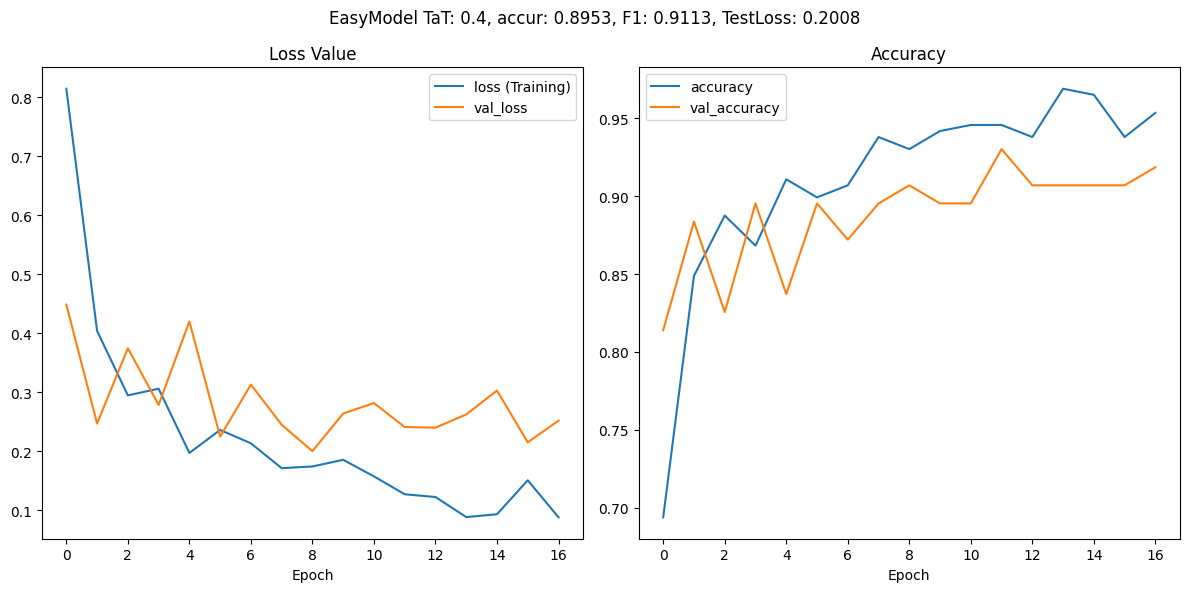

Train loss: 0.08764901012182236
Test val_loss: 0.2516292929649353
Train accuracy: 0.9534883499145508
Accuracy Score: 0.8953488372093024
F1 Score: 0.9113373471994162
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.94      0.97        18
         1.0       1.00      0.92      0.96        13
         2.0       0.85      0.85      0.85        27
         3.0       0.83      0.89      0.86        28

    accuracy                           0.90        86
   macro avg       0.92      0.90      0.91        86
weighted avg       0.90      0.90      0.90        86



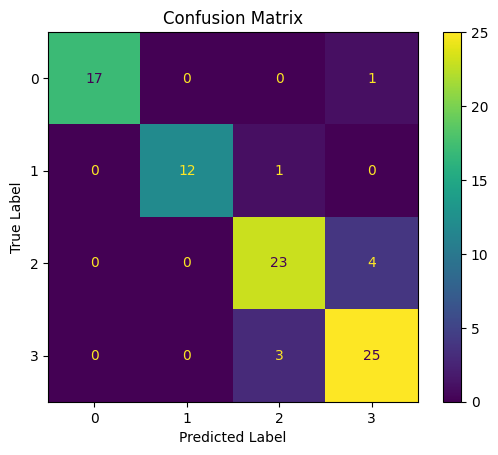

In [2]:
def build_easyModel():
    input_layer = Input(shape=(WS_B, 1))
    x = Conv1D(64, kernel_size=40, strides=10, activation='relu')(input_layer)
    x = MaxPooling1D(pool_size=2)(x)
    x = Flatten()(x)

    z = Conv1D(64, kernel_size=40, strides=10, activation='relu')(input_layer)
    z = MaxPooling1D(pool_size=2)(z)
    z = Flatten()(z)

    merged = concatenate([x, z])
    common_layer = Dense(64, activation='relu')(merged)
    output_layer = Dense(N_CLASS, activation='softmax')(common_layer)
    model = Model(inputs=[input_layer, input_layer], outputs=output_layer)
    return model

model_name = "1D_easy1Conv"
model = build_easyModel()
model.summary()
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#TRAIN THE MODEL
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model.fit([X_train_x, X_train_z], y_train, epochs=32, batch_size=32, 
                    validation_data=([X_val_x, X_val_z], y_val), verbose=1, callbacks=[early_stopping])

loss, accuracy = model.evaluate([X_test_x, X_test_z], y_test)

# Predict labels for test data
y_pred = model.predict([X_test_x, X_test_z])
y_pred_labels = np.argmax(y_pred, axis=1)

f1 = f1_score(y_test, y_pred_labels, average='macro')
accuracy = accuracy_score(y_test, y_pred_labels)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()

# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_labels))

conf_mat = confusion_matrix(y_test, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=DISP_LABELS)
disp.plot()  # You can adjust the colormap as needed
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# 2 CONVs 

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 3000, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 748, 64)   │        704 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 748, 64)   │        704 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 374, 64)   │          0 │ conv1d_2[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 374, 64)   │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 371, 128)  │     32,896 │ max_pooling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 371, 128)  │     32,896 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 185, 128)  │          0 │ conv1d_3[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_5     │ (None, 185, 128)  │          0 │ conv1d_5[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 23680)     │          0 │ max_pooling1d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 23680)     │          0 │ max_pooling1d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 47360)     │          0 │ flatten_2[0][0],  │
│ (Concatenate)       │                   │            │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 47360)     │          0 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │  3,031,104 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 4)         │        260 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,098,564 (11.82 MB)

 Trainable params: 3,098,564 (11.82 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 308ms/step - accuracy: 0.4582 - loss: 1.1880 - val_accuracy: 0.8372 - val_loss: 0.4776
Epoch 2/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8815 - loss: 0.3763 - val_accuracy: 0.8721 - val_loss: 0.4209
Epoch 3/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8393 - loss: 0.3932 - val_accuracy: 0.8256 - val_loss: 0.5784
Epoch 4/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8976 - loss: 0.3712 - val_accuracy: 0.9070 - val_loss: 0.2731
Epoch 5/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9330 - loss: 0.2079 - val_accuracy: 0.8837 - val_loss: 0.3251
Epoch 6/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8681 - loss: 0.2497 - val_accuracy: 0.8721 - val_loss: 0.4598
Epoch 7/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9062 - loss: 0.2275 - val_accuracy: 0.9070 - val_loss: 0.2552
Epoch 8/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9140 - loss: 0.1767 - val_accuracy: 0.9302 - val_loss: 0.1835

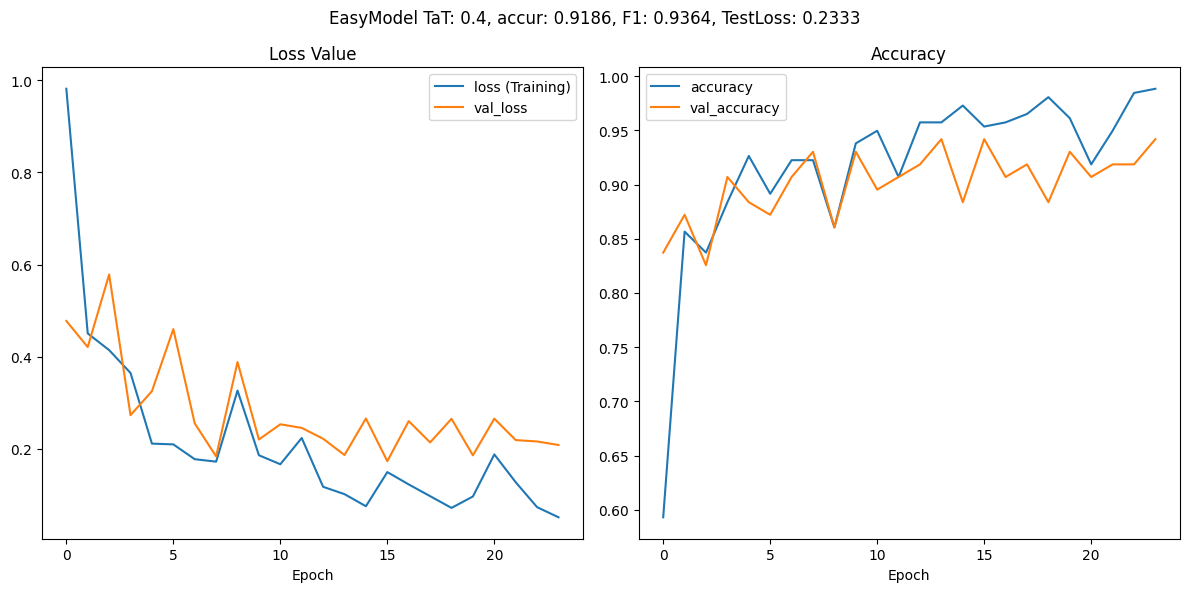

Train loss: 0.0512552484869957
Test val_loss: 0.2082904726266861
Train accuracy: 0.9883720874786377
Accuracy Score: 0.9186046511627907
F1 Score: 0.9363636363636363
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        18
         1.0       1.00      1.00      1.00        13
         2.0       0.86      0.89      0.87        27
         3.0       0.89      0.86      0.87        28

    accuracy                           0.92        86
   macro avg       0.94      0.94      0.94        86
weighted avg       0.92      0.92      0.92        86



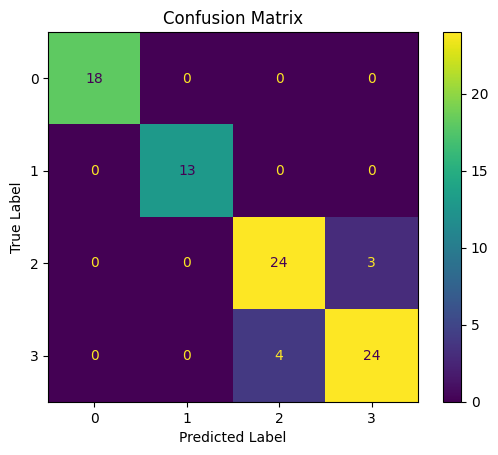

In [3]:
def build_easyModel():
    input = Input(shape=(WS_B, 1))

    x = Conv1D(64, kernel_size=10, strides=4, activation='relu')(input)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(128, kernel_size=4, activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Flatten()(x)

    z = Conv1D(64, kernel_size=10, strides=4, activation='relu')(input)
    z = MaxPooling1D(pool_size=2)(z)
    z = Conv1D(128, kernel_size=4, activation='relu')(z)
    z = MaxPooling1D(pool_size=2)(z)
    z = Flatten()(z)

    merged = concatenate([x, z])
    merged = Dropout(0.2)(merged)
    common_layer = Dense(64, activation='relu')(merged)
    output_layer = Dense(N_CLASS, activation='softmax')(common_layer)

    model = Model(inputs=[input, input], outputs=output_layer)
    return model

model = build_easyModel()
model.summary()
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#TRAIN THE MODEL
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model.fit([X_train_x, X_train_z], y_train, epochs=32, batch_size=32, 
                    validation_data=([X_val_x, X_val_z], y_val), verbose=1, callbacks=[early_stopping])

loss, accuracy = model.evaluate([X_test_x, X_test_z], y_test)

# Predict labels for test data
y_pred = model.predict([X_test_x, X_test_z])
y_pred_labels = np.argmax(y_pred, axis=1)

f1 = f1_score(y_test, y_pred_labels, average='macro')
accuracy = accuracy_score(y_test, y_pred_labels)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()

# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_labels))

conf_mat = confusion_matrix(y_test, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=DISP_LABELS)
disp.plot()  # You can adjust the colormap as needed
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [4]:
# model_name = "1D_LDG_F+F_2Cnv_94"
# to_save_model(model, history, loss, accuracy, f1, model_name, y_test, y_pred_labels, build_easyModel)
# #model.save(f"{model_name}.h5")
# from tensorflow.keras.models import save_model
# save_dir = "saved_models/"
# os.makedirs(save_dir, exist_ok=True)
# model_path = os.path.join(save_dir, f"{model_name}.keras")
# save_model(model, model_path)

# 3 CONVs

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 3000, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 3000, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 297, 64)   │      2,624 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 297, 64)   │      2,624 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_6     │ (None, 148, 64)   │          0 │ conv1d_6[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_9     │ (None, 148, 64)   │          0 │ conv1d_9[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 36, 128)   │     65,664 │ max_pooling1d_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 36, 128)   │     65,664 │ max_pooling1d_9[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_7     │ (None, 18, 128)   │          0 │ conv1d_7[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_10    │ (None, 18, 128)   │          0 │ conv1d_10[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 17, 256)   │     65,792 │ max_pooling1d_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 17, 256)   │     65,792 │ max_pooling1d_10… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_8     │ (None, 8, 256)    │          0 │ conv1d_8[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_11    │ (None, 8, 256)    │          0 │ conv1d_11[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 2048)      │          0 │ max_pooling1d_8[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 2048)      │          0 │ max_pooling1d_11… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 4096)      │          0 │ flatten_4[0][0],  │
│ (Concatenate)       │                   │            │ flatten_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │    524,416 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 4)         │        516 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 793,092 (3.03 MB)

 Trainable params: 793,092 (3.03 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/32


2024-06-24 17:30:52.811087: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.06GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 437ms/step - accuracy: 0.4851 - loss: 1.1871 - val_accuracy: 0.6628 - val_loss: 1.1103
Epoch 2/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7354 - loss: 0.8639 - val_accuracy: 0.8140 - val_loss: 0.4552
Epoch 3/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8392 - loss: 0.4343 - val_accuracy: 0.8721 - val_loss: 0.3214
Epoch 4/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8346 - loss: 0.3239 - val_accuracy: 0.8023 - val_loss: 0.4889
Epoch 5/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7879 - loss: 0.5998 - val_accuracy: 0.8605 - val_loss: 0.3469
Epoch 6/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8766 - loss: 0.3247 - val_accuracy: 0.8837 - val_loss: 0.2896
Epoch 7/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8900 - loss: 0.2344 - val_accuracy: 0.9070 - val_loss: 0.2238
Epoch 8/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8523 - loss: 0.3334 - val_accuracy: 0.8721 - val_loss: 0.2919
Epoch 9/32
9/9 ━━

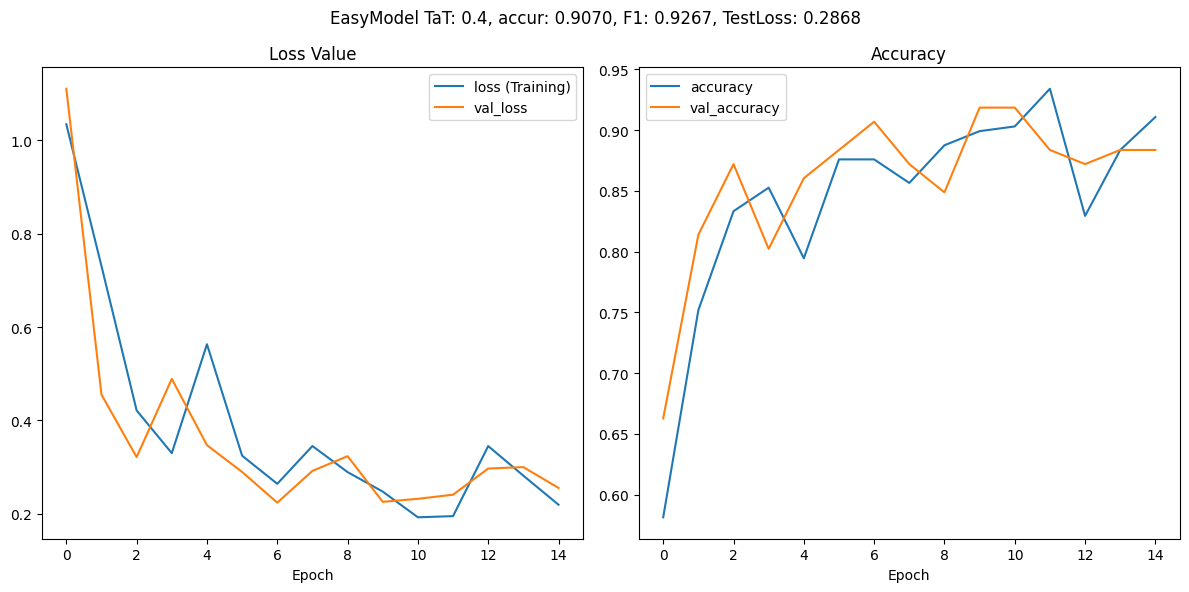

Train loss: 0.2193918377161026
Test val_loss: 0.25534501671791077
Train accuracy: 0.9108527302742004
Accuracy Score: 0.9069767441860465
F1 Score: 0.9266666666666666
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        18
         1.0       1.00      1.00      1.00        13
         2.0       0.91      0.78      0.84        27
         3.0       0.81      0.93      0.87        28

    accuracy                           0.91        86
   macro avg       0.93      0.93      0.93        86
weighted avg       0.91      0.91      0.91        86



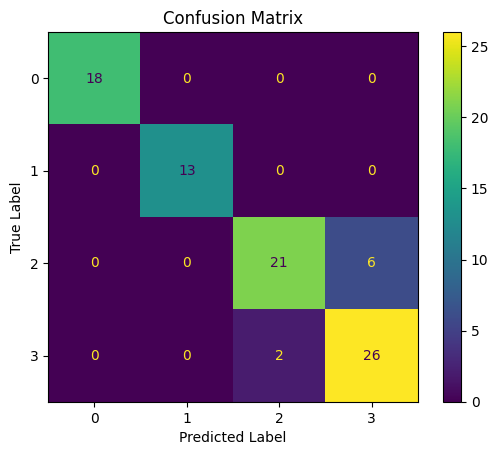

In [5]:
def build_easyModel():
    input_x = Input(shape=(WS_B, 1))
    input_z = Input(shape=(WS_B, 1))

    x = Conv1D(64, kernel_size=40, strides=10, activation='relu')(input_x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(128, kernel_size=8, strides=4, activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(256, kernel_size=2, activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Flatten()(x)

    z = Conv1D(64, kernel_size=40, strides=10, activation='relu')(input_z)
    z = MaxPooling1D(pool_size=2)(z)
    z = Conv1D(128, kernel_size=8, strides=4, activation='relu')(z)
    z = MaxPooling1D(pool_size=2)(z)
    z = Conv1D(256, kernel_size=2, activation='relu')(z)
    z = MaxPooling1D(pool_size=2)(z)
    z = Flatten()(z)

    merged = concatenate([x, z])
    common_layer = Dense(128, activation='relu')(merged)
    common_layer = Dropout(0.2)(common_layer)
    output_layer = Dense(N_CLASS, activation='softmax')(common_layer)

    model = Model(inputs=[input_x, input_z], outputs=output_layer)
    return model

model = build_easyModel()
model.summary()
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#TRAIN THE MODEL
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model.fit([X_train_x, X_train_z], y_train, epochs=32, batch_size=32, 
                    validation_data=([X_val_x, X_val_z], y_val), verbose=1, callbacks=[early_stopping])

loss, accuracy = model.evaluate([X_test_x, X_test_z], y_test)

# Predict labels for test data
y_pred = model.predict([X_test_x, X_test_z])
y_pred_labels = np.argmax(y_pred, axis=1)

f1 = f1_score(y_test, y_pred_labels, average='macro')
accuracy = accuracy_score(y_test, y_pred_labels)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()

# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_labels))

conf_mat = confusion_matrix(y_test, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=DISP_LABELS)
disp.plot()  # You can adjust the colormap as needed
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# 4 CONVs or Still "COMPLEX"

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 3000, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 3000, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 746, 64)   │      1,344 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 746, 64)   │      1,344 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_12    │ (None, 373, 64)   │          0 │ conv1d_12[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_15    │ (None, 373, 64)   │          0 │ conv1d_16[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 90, 128)   │    131,200 │ max_pooling1d_12… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_17 (Conv1D)  │ (None, 90, 128)   │    131,200 │ max_pooling1d_15… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 90, 128)   │          0 │ conv1d_13[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 90, 128)   │          0 │ conv1d_17[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 83, 128)   │    131,200 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_18 (Conv1D)  │ (None, 83, 128)   │    131,200 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_13    │ (None, 41, 128)   │          0 │ conv1d_14[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_16    │ (None, 41, 128)   │          0 │ conv1d_18[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 38, 256)   │    131,328 │ max_pooling1d_13… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_19 (Conv1D)  │ (None, 38, 256)   │    131,328 │ max_pooling1d_16… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_14    │ (None, 19, 256)   │          0 │ conv1d_15[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_17    │ (None, 19, 256)   │          0 │ conv1d_19[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_6 (Flatten) │ (None, 4864)      │          0 │ max_pooling1d_14… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_7 (Flatten) │ (None, 4864)      │          0 │ max_pooling1d_17… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 9728)      │          0 │ flatten_6[0][0],

 Total params: 1,413,060 (5.39 MB)

 Trainable params: 1,413,060 (5.39 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 622ms/step - accuracy: 0.3414 - loss: 1.2484 - val_accuracy: 0.7093 - val_loss: 0.6248
Epoch 2/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7716 - loss: 0.5416 - val_accuracy: 0.7674 - val_loss: 0.3975
Epoch 3/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8198 - loss: 0.3939 - val_accuracy: 0.8256 - val_loss: 0.4944
Epoch 4/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8436 - loss: 0.3664 - val_accuracy: 0.8605 - val_loss: 0.2933
Epoch 5/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8793 - loss: 0.2690 - val_accuracy: 0.8837 - val_loss: 0.2705
Epoch 6/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9036 - loss: 0.2398 - val_accuracy: 0.8488 - val_loss: 0.3124
Epoch 7/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8976 - loss: 0.1994 - val_accuracy: 0.8953 - val_loss: 0.2249
Epoch 8/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8243 - loss: 0.3228 - val_accuracy: 0.8140 - val_loss: 0.379

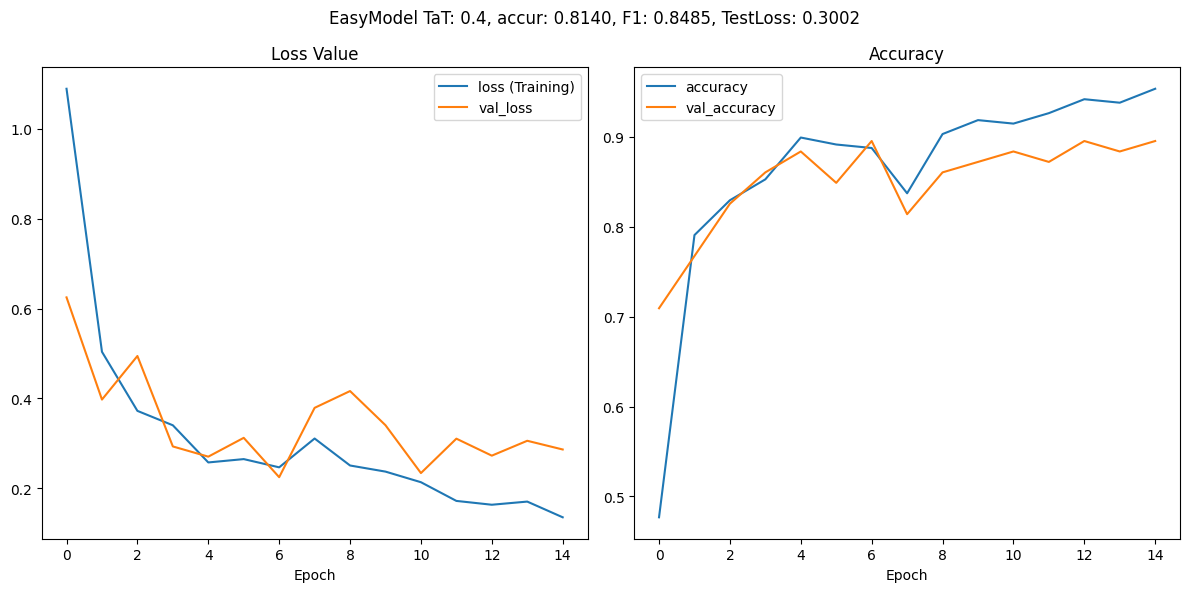

Train loss: 0.13570135831832886
Test val_loss: 0.28649652004241943
Train accuracy: 0.9534883499145508
Accuracy Score: 0.813953488372093
F1 Score: 0.8484848484848484
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        18
         1.0       0.93      1.00      0.96        13
         2.0       0.70      0.70      0.70        27
         3.0       0.74      0.71      0.73        28

    accuracy                           0.81        86
   macro avg       0.84      0.85      0.85        86
weighted avg       0.81      0.81      0.81        86



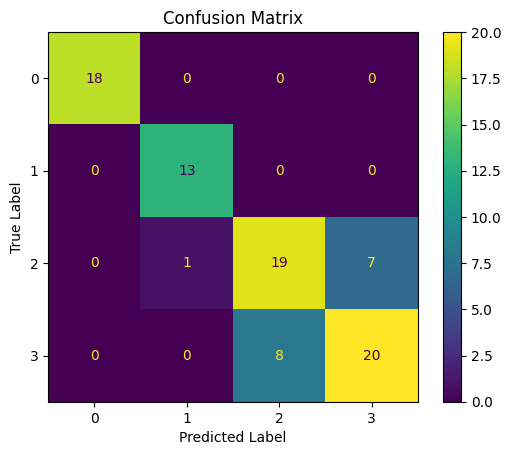

In [6]:
def build_easyModel():
    input_x = Input(shape=(WS_B, 1))
    input_z = Input(shape=(WS_B, 1))

    # Branch for Force_X
    x = Conv1D(filters=64, kernel_size=20, strides=4, activation='relu')(input_x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(filters=128, kernel_size=16, strides=4, activation='relu')(x)
    x = Dropout(rate=0.1)(x)
    x = Conv1D(filters=128, kernel_size=8, activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(filters=256, kernel_size=4, activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Flatten()(x)

    # Branch for Force_Z
    z = Conv1D(filters=64, kernel_size=20, strides=4, activation='relu')(input_z)
    z = MaxPooling1D(pool_size=2)(z)
    z = Conv1D(filters=128, kernel_size=16, strides=4, activation='relu')(z)
    z = Dropout(rate=0.1)(z)
    z = Conv1D(filters=128, kernel_size=8, activation='relu')(z)
    z = MaxPooling1D(pool_size=2)(z)
    z = Conv1D(filters=256, kernel_size=4, activation='relu')(z)
    z = MaxPooling1D(pool_size=2)(z)
    z = Flatten()(z)

    # Merging branches
    merged = concatenate([x, z])
    common_layer = Dense(64, activation='relu')(merged)
    output_layer = Dense(N_CLASS, activation='softmax')(common_layer)

    model = Model(inputs=[input_x, input_z], outputs=output_layer)
    return model


model = build_easyModel()
model.summary()
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


#TRAIN THE MODEL
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model.fit([X_train_x, X_train_z], y_train, epochs=32, batch_size=32, 
                    validation_data=([X_val_x, X_val_z], y_val), verbose=1, callbacks=[early_stopping])

loss, accuracy = model.evaluate([X_test_x, X_test_z], y_test)

# Predict labels for test data
y_pred = model.predict([X_test_x, X_test_z])
y_pred_labels = np.argmax(y_pred, axis=1)

f1 = f1_score(y_test, y_pred_labels, average='macro')
accuracy = accuracy_score(y_test, y_pred_labels)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()

# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_labels))

conf_mat = confusion_matrix(y_test, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=DISP_LABELS)
disp.plot()  # You can adjust the colormap as needed
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# 5 CONVS